## Imports

In [28]:
import torch
import torchvision
import cv2
import urllib
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from sklearn.kernel_approximation import RBFSampler
from sklearn import preprocessing

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
    import torchmetrics
    
except ImportError:
    %pip install einops torchmetrics
    from einops import rearrange
    import torchmetrics

## Image manipulation

In [29]:
file_path = 'cards.jpg'
if os.path.exists(file_path):
    print('wall.jpg exists')
else:
    !wget 'https://raw.githubusercontent.com/23110281/host/refs/heads/main/cards.jpg' -O 'cards.jpg'
#     !wget 'https://raw.githubusercontent.com/23110281/host/refs/heads/main/pikachu.jpg' -O 'wall.jpg'
#     !wget 'https://raw.githubusercontent.com/23110281/host/refs/heads/main/mouse.png' -O 'wall.jpg'
#     !wget 'https://raw.githubusercontent.com/23110281/host/refs/heads/main/peakpx.jpg' -O 'wall.jpg'


wall.jpg exists


torch.Size([3, 2455, 1964])


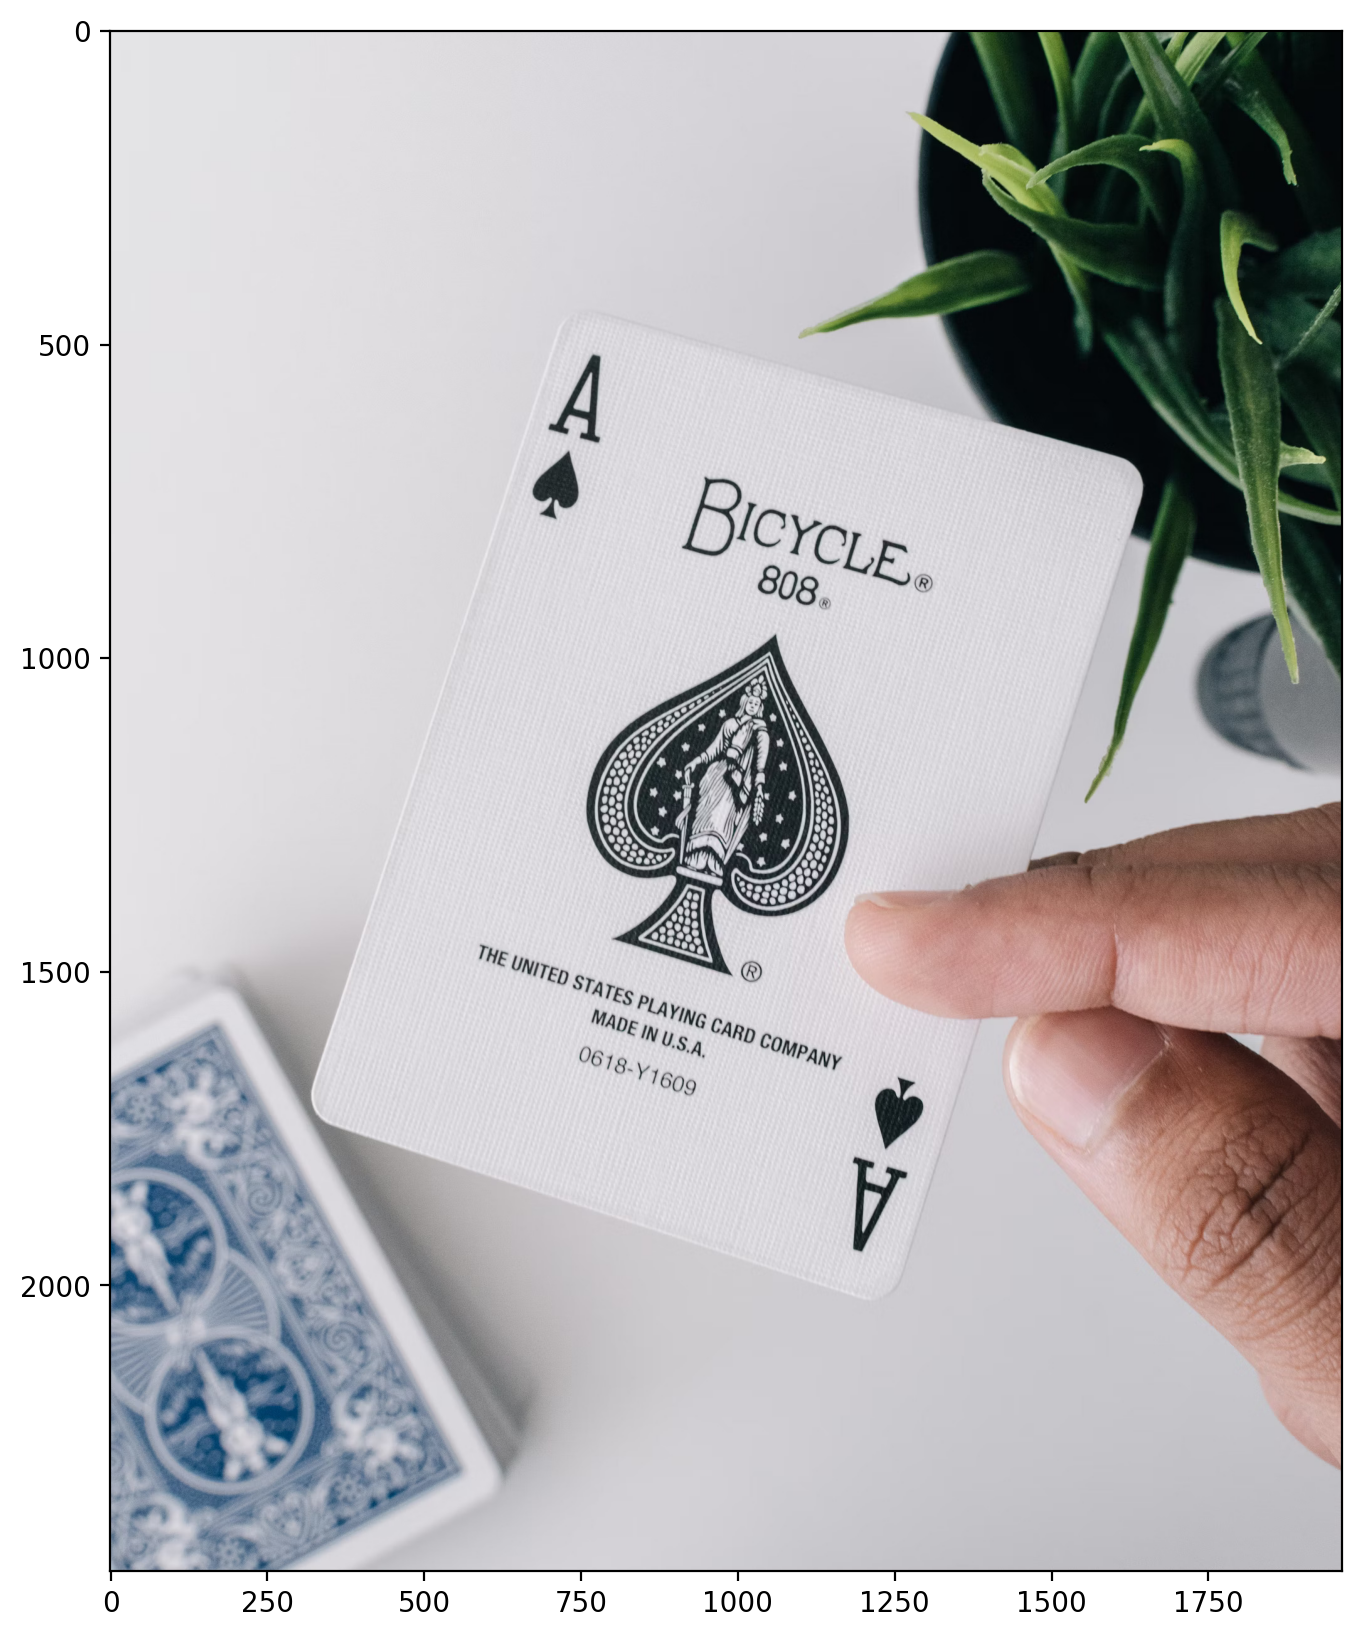

In [30]:
img = torchvision.io.read_image("cards.jpg")
print(img.shape)

plt.figure(figsize=(10, 10))
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [31]:
scaler = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaled_img = scaler.transform(img.reshape(-1, 1)).reshape(img.shape)
scaled_img = torch.tensor(scaled_img).float().to(device)
print(scaled_img.shape)
print(scaled_img)

torch.Size([3, 2455, 1964])
tensor([[[0.9157, 0.9157, 0.9157,  ..., 0.0161, 0.0161, 0.0161],
         [0.9157, 0.9157, 0.9157,  ..., 0.0161, 0.0161, 0.0161],
         [0.9157, 0.9157, 0.9157,  ..., 0.0161, 0.0161, 0.0161],
         ...,
         [0.7590, 0.7430, 0.7309,  ..., 0.7711, 0.7751, 0.7791],
         [0.7671, 0.7510, 0.7390,  ..., 0.7711, 0.7711, 0.7711],
         [0.7711, 0.7631, 0.7430,  ..., 0.7671, 0.7671, 0.7631]],

        [[0.9157, 0.9157, 0.9157,  ..., 0.0321, 0.0321, 0.0321],
         [0.9157, 0.9157, 0.9157,  ..., 0.0321, 0.0321, 0.0321],
         [0.9157, 0.9157, 0.9157,  ..., 0.0321, 0.0321, 0.0321],
         ...,
         [0.7952, 0.7831, 0.7711,  ..., 0.7631, 0.7671, 0.7711],
         [0.8032, 0.7912, 0.7791,  ..., 0.7631, 0.7631, 0.7631],
         [0.8072, 0.7992, 0.7831,  ..., 0.7590, 0.7590, 0.7550]],

        [[0.9237, 0.9237, 0.9237,  ..., 0.0361, 0.0361, 0.0361],
         [0.9237, 0.9237, 0.9237,  ..., 0.0361, 0.0361, 0.0361],
         [0.9237, 0.9237, 0.92

torch.Size([3, 200, 200])


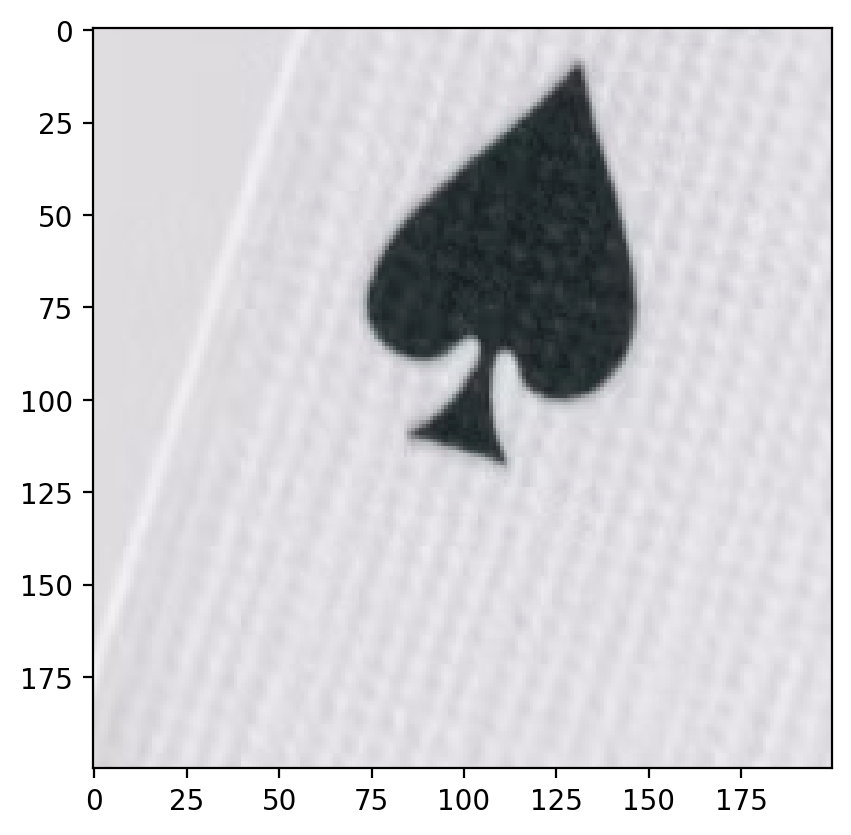

In [32]:
crop_og = torchvision.transforms.functional.crop(scaled_img.cpu(), 660, 600, 200, 200)
print(crop_og.shape)

plt.imshow(rearrange(crop_og, 'c h w -> h w c').cpu().numpy())

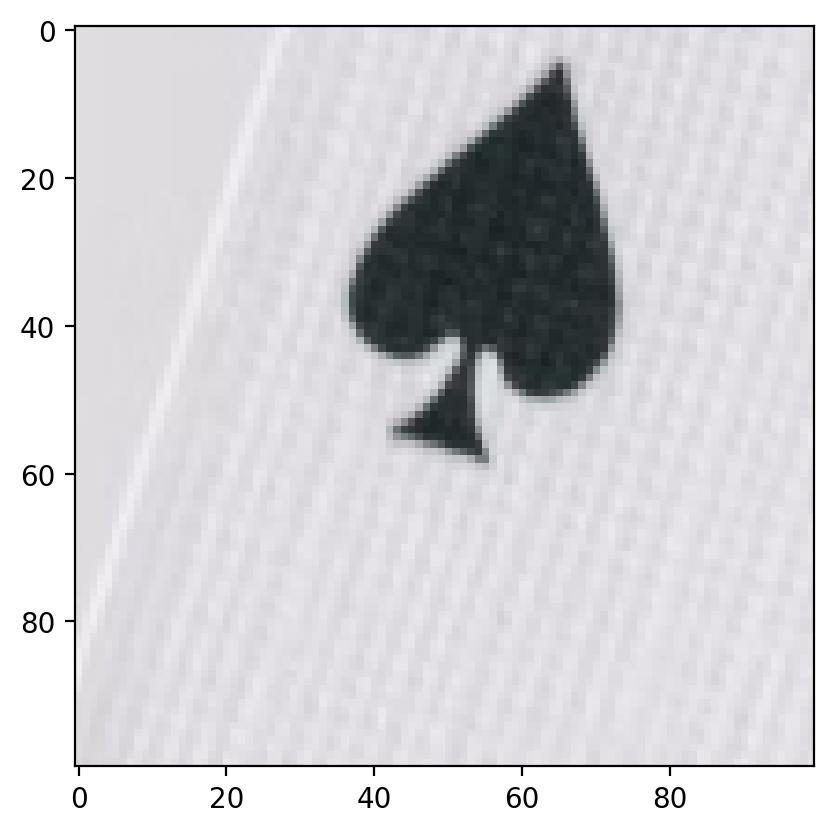

In [33]:
crop = torch.tensor(rearrange(cv2.resize(rearrange(crop_og.numpy(), 'c h w -> h w c'), (100, 100)), 'h w c -> c h w'))
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

## 1. Super-resolution

In [34]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    height *= scale
    width *= scale

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [35]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [36]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    print(f"Epoch {epochs} loss: {loss.item():.6f}")
    return loss.item()

In [55]:
def upscale(crop=crop, num_features = 10000, sigma = 0.03, learning_rate = 0.01, epochs = 100):
    
    X, Y = create_coordinate_map(crop)

    scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X.cpu())
    scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)

    rff = RBFSampler(n_components=num_features, gamma=1/(2*sigma**2), random_state=42)
    X_rff = torch.tensor(rff.fit_transform(scaled_X.cpu().numpy())).float().to(device)
    print(X_rff.shape)

    print(X_rff)

    net = LinearModel(X_rff.shape[1],3).to(device)
        
    Y = Y.to(device)
    train(net, learning_rate, X_rff, Y, epochs)
    
    n0, h0, w0 = crop.shape
    
    with torch.no_grad():
        outputs_og = net(X_rff)
        reconstructed_img = outputs_og.to(device)
        reconstructed_img = rearrange(reconstructed_img, '(h w) c -> c h w', h=h0, w=w0)

    del X_rff, X, Y, scaled_X

    X_, Y_ = create_coordinate_map(crop, scale = 2)
    print("Shape of X_ = ",X_.shape,"\nShape of Y_ = ", Y_.shape)
    print("X_:\n",X_,"\nY_:\n", Y_)

    scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X_.cpu())
    scaled_X_ = torch.tensor(scaler.transform(X_.cpu())).float().to(device)
    print("scaled_X shape: ",scaled_X_.shape)
    print(scaled_X_)

    X_rff = rff.transform(scaled_X_.cpu().numpy())
    X_rff = torch.tensor(X_rff).float().to(device)

    print(X_rff.shape)
    print(X_rff)

    num_channels, height, width = crop_og.shape

    with torch.no_grad():
        outputs = net(X_rff)
        pred_img = outputs.to(device)
        print("Pred image shape\n :", pred_img.shape)
        pred_img = torch.Tensor(rearrange(pred_img, '(h w) c -> c h w', h=height, w=width))
    
    del X_rff, X_, Y_, scaled_X_

    return pred_img, reconstructed_img

In [ ]:
def plot_images(crop_og, upscaled_image, reconstructed_image=0):
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    
    ax[0].imshow(rearrange(reconstructed_image, 'c h w -> h w c').numpy())
    ax[0].set_title('Reconstructed Image')
    
    ax[1].imshow(rearrange(upscaled_image, 'c h w -> h w c'))
    ax[1].set_title('Upscaled Image')
    
    ax[2].imshow(rearrange(crop_og, 'c h w -> h w c').numpy())
    ax[2].set_title('Cropped Image')    
    
    plt.tight_layout()
    plt.show()

In [39]:
crop.shape

torch.Size([3, 100, 100])

torch.Size([10000, 50000])
tensor([[ 4.0644e-03,  2.5508e-04, -1.6440e-03,  ..., -5.2064e-03,
         -6.3197e-03, -5.9228e-03],
        [ 3.7353e-03, -1.7885e-05,  2.3341e-03,  ..., -4.0331e-03,
         -6.2206e-03, -6.0826e-03],
        [ 3.3899e-03, -2.9082e-04,  5.3856e-03,  ..., -2.5555e-03,
         -5.9961e-03, -6.2027e-03],
        ...,
        [-5.7255e-03, -4.5301e-03, -6.2475e-03,  ...,  3.5208e-03,
          4.7898e-03,  9.6558e-04],
        [-5.8905e-03, -4.7164e-03, -5.5960e-03,  ...,  1.9586e-03,
          5.3266e-03,  1.4672e-03],
        [-6.0298e-03, -4.8938e-03, -2.7233e-03,  ...,  2.4852e-04,
          5.7559e-03,  1.9593e-03]], device='cuda:0')
Epoch 0 loss: 0.687862
Epoch 100 loss: 0.425804
Epoch 200 loss: 0.262744
Epoch 300 loss: 0.157984
Epoch 400 loss: 0.091984
Epoch 500 loss: 0.051676
Epoch 600 loss: 0.027961
Epoch 700 loss: 0.014584
Epoch 800 loss: 0.007379
Epoch 900 loss: 0.003686
Epoch 1000 loss: 0.001887
Epoch 1100 loss: 0.001049
Epoch 1200 loss: 0.00067

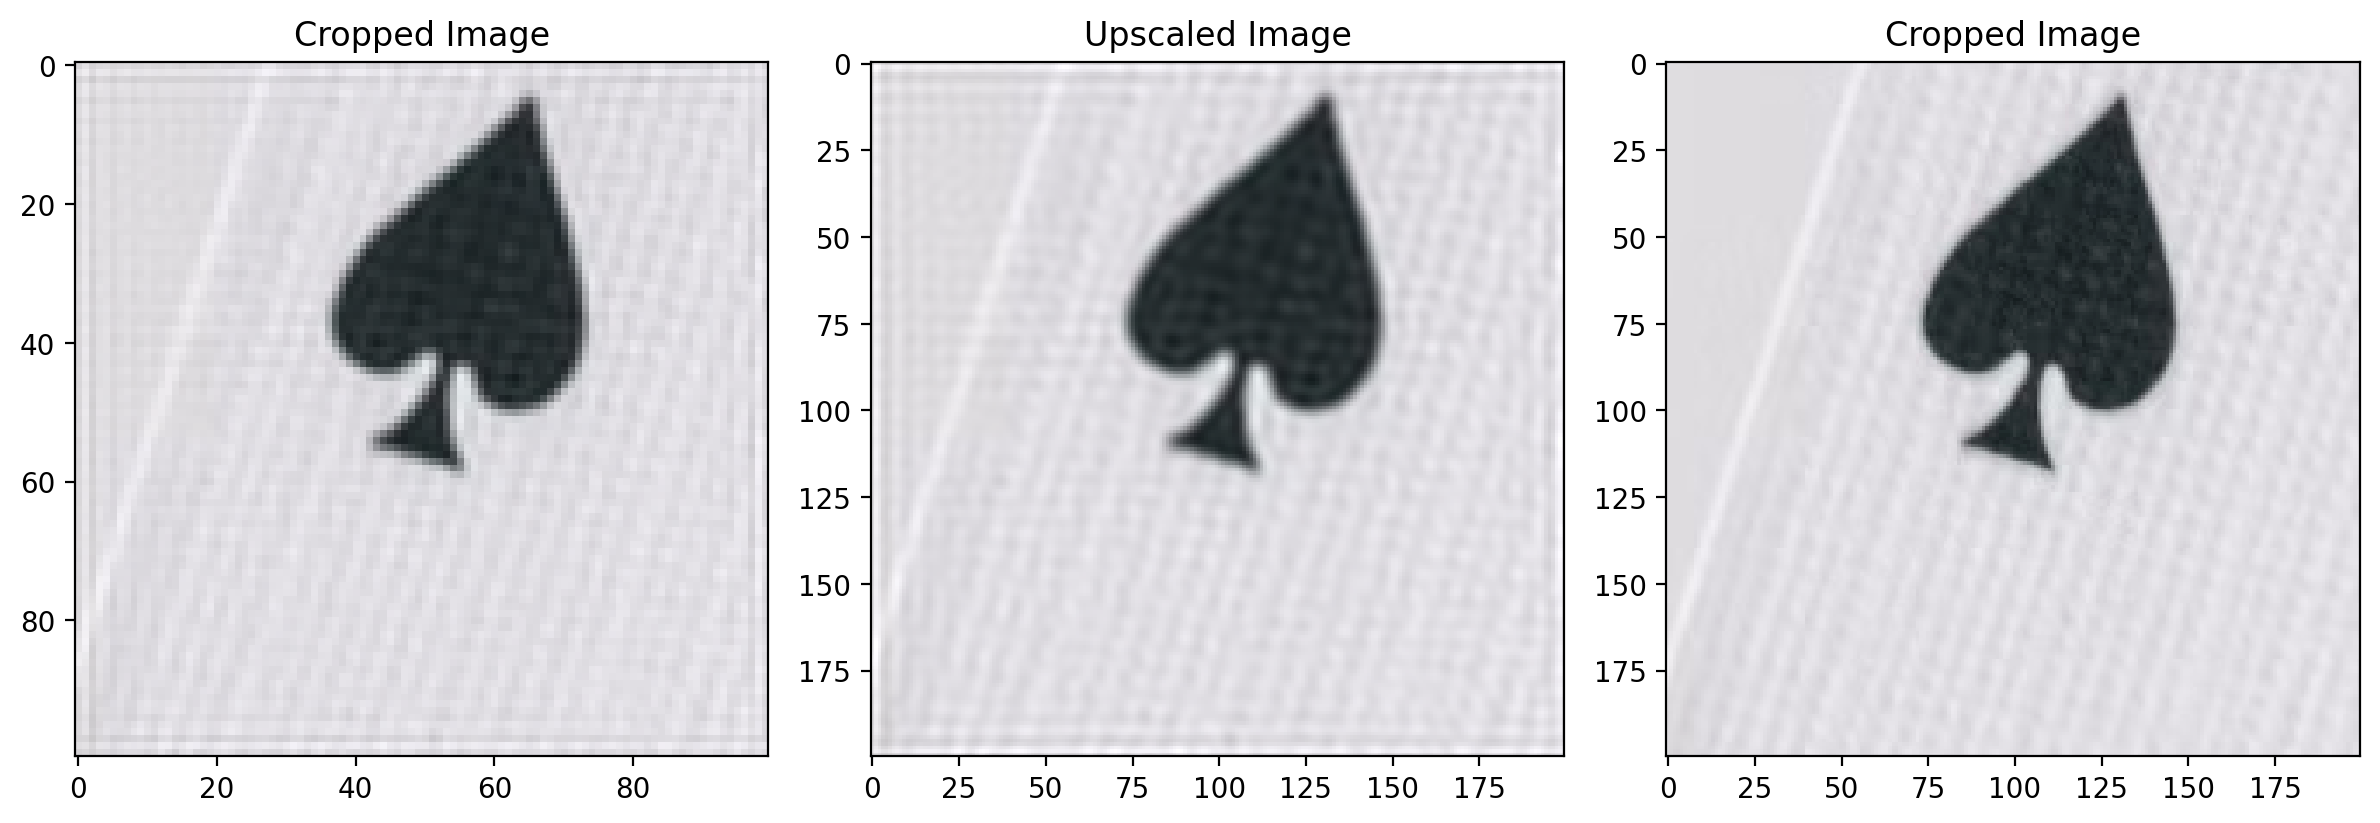

In [48]:
num_features = 50000
sigma = 0.03
learning_rate = 0.0008
epochs = 2000

pred_image, reconstructed_img = upscale(crop, num_features, sigma, learning_rate, epochs)
plot_images(crop_og.cpu(), pred_image.cpu(), reconstructed_img.cpu())

## 2. quantitative comparison

In [41]:
def quantitative_manual(img1,img2):
    rmse = torch.sqrt(torch.mean((img1 - img2) ** 2))
    psnr = 20 * torch.log10(1.0 / rmse)
    return rmse.item(), psnr.item()

In [ ]:
rmse, psnr = quantitative_manual(crop_og.cpu(), pred_image.cpu())
print("RMSE:", rmse)
print("PSNR:", psnr)

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize lists to store results
results_num_features = []
results_epochs = []
results_sigma = []

# Default values
default_num_features = 37500
default_sigma = 0.03
default_learning_rate = 0.05
default_epochs = 1200

# Varying parameters
num_features_list = [1000, 10000, 20000, 30000, 40000, 50000]
epochs_list = list(range(500, 3000, 500))
sigma_list = [0.008, 0.03, 0.02, 0.1, 1, 2]

# Loop through varying num_features
for num_features in num_features_list:
    pred_image, r = upscale(num_features=num_features, sigma=default_sigma, learning_rate=default_learning_rate, epochs=default_epochs)
    rmse, psnr = quantitative_manual(crop_og.cpu(), pred_image.cpu())
    results_num_features.append((num_features, rmse, psnr))
    
    del r, pred_image

# Loop through varying epochs
for epochs in epochs_list:
    pred_image, r = upscale(num_features=default_num_features, sigma=default_sigma, learning_rate=default_learning_rate, epochs=epochs)
    rmse, psnr = quantitative_manual(crop_og.cpu(), pred_image.cpu())
    results_epochs.append((epochs, rmse, psnr))
    
    del r, pred_image

# Loop through varying sigma
for sigma in sigma_list:
    pred_image, r = upscale(num_features=default_num_features, sigma=sigma, learning_rate=default_learning_rate, epochs=default_epochs)
    rmse, psnr = quantitative_manual(crop_og.cpu(), pred_image.cpu())
    results_sigma.append((sigma, rmse, psnr))
    
    del r, pred_image

# Create DataFrames from the results
df_num_features = pd.DataFrame(results_num_features, columns=['num_features', 'rmse', 'psnr'])
df_epochs = pd.DataFrame(results_epochs, columns=['epochs', 'rmse', 'psnr'])
df_sigma = pd.DataFrame(results_sigma, columns=['sigma', 'rmse', 'psnr'])


torch.Size([10000, 1000])
tensor([[-0.0259,  0.0352, -0.0368,  ..., -0.0409,  0.0443, -0.0360],
        [-0.0447,  0.0447, -0.0357,  ..., -0.0238,  0.0434, -0.0188],
        [-0.0267,  0.0374, -0.0346,  ...,  0.0015,  0.0419,  0.0031],
        ...,
        [ 0.0225,  0.0433,  0.0380,  ...,  0.0410,  0.0077, -0.0056],
        [-0.0180,  0.0288,  0.0370,  ...,  0.0440,  0.0125, -0.0262],
        [-0.0437,  0.0034,  0.0360,  ...,  0.0319,  0.0171, -0.0404]],
       device='cuda:0')
Epoch 0 loss: 0.678513
Epoch 100 loss: 0.002310
Epoch 200 loss: 0.001657
Epoch 300 loss: 0.001558
Epoch 400 loss: 0.001525
Epoch 500 loss: 0.001504
Epoch 600 loss: 0.001490
Epoch 700 loss: 0.001480
Epoch 800 loss: 0.001471
Epoch 900 loss: 0.001463
Epoch 1000 loss: 0.001457
Epoch 1100 loss: 0.001451
Epoch 1200 loss: 0.001446
Shape of X_ =  torch.Size([40000, 2]) 
Shape of Y_ =  torch.Size([10000, 3])
X_:
 tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
       

In [61]:
display(df_num_features)
display(df_epochs)
display(df_sigma)

,num_features,rmse,psnr
0,1000,0.040699,27.808338
1,10000,0.018944,34.450768
2,20000,0.017121,35.329346
3,30000,0.016815,35.486012
4,40000,0.016364,35.722019
5,50000,0.016314,35.749046


,epochs,rmse,psnr
0,500,0.016005,35.914944
1,1000,0.016416,35.694839
2,1500,0.016925,35.429455
3,2000,0.016864,35.461025
4,2500,0.016448,35.677952


,sigma,rmse,psnr
0,0.008,0.180781,14.856929
1,0.030,0.016641,35.576447
2,0.020,0.014288,36.900440
3,0.100,0.045774,26.787672
4,1.000,0.118310,18.539574
5,2.000,0.164115,15.697061


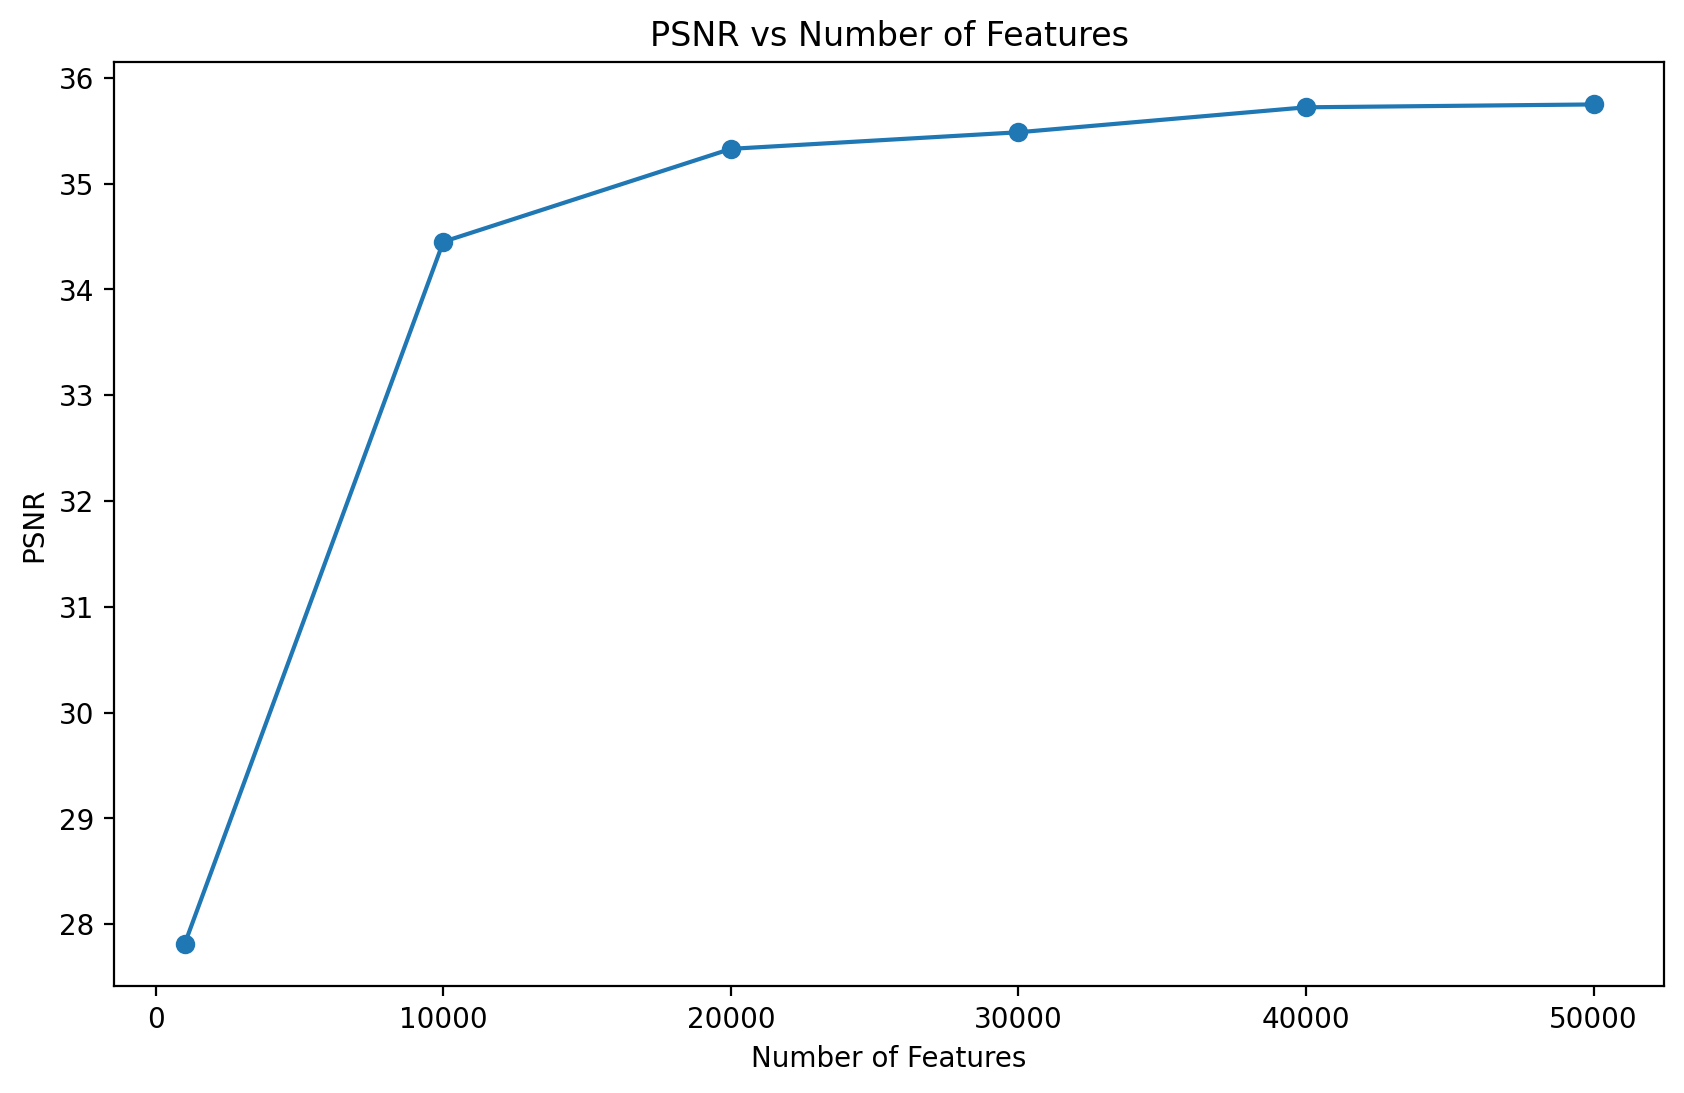

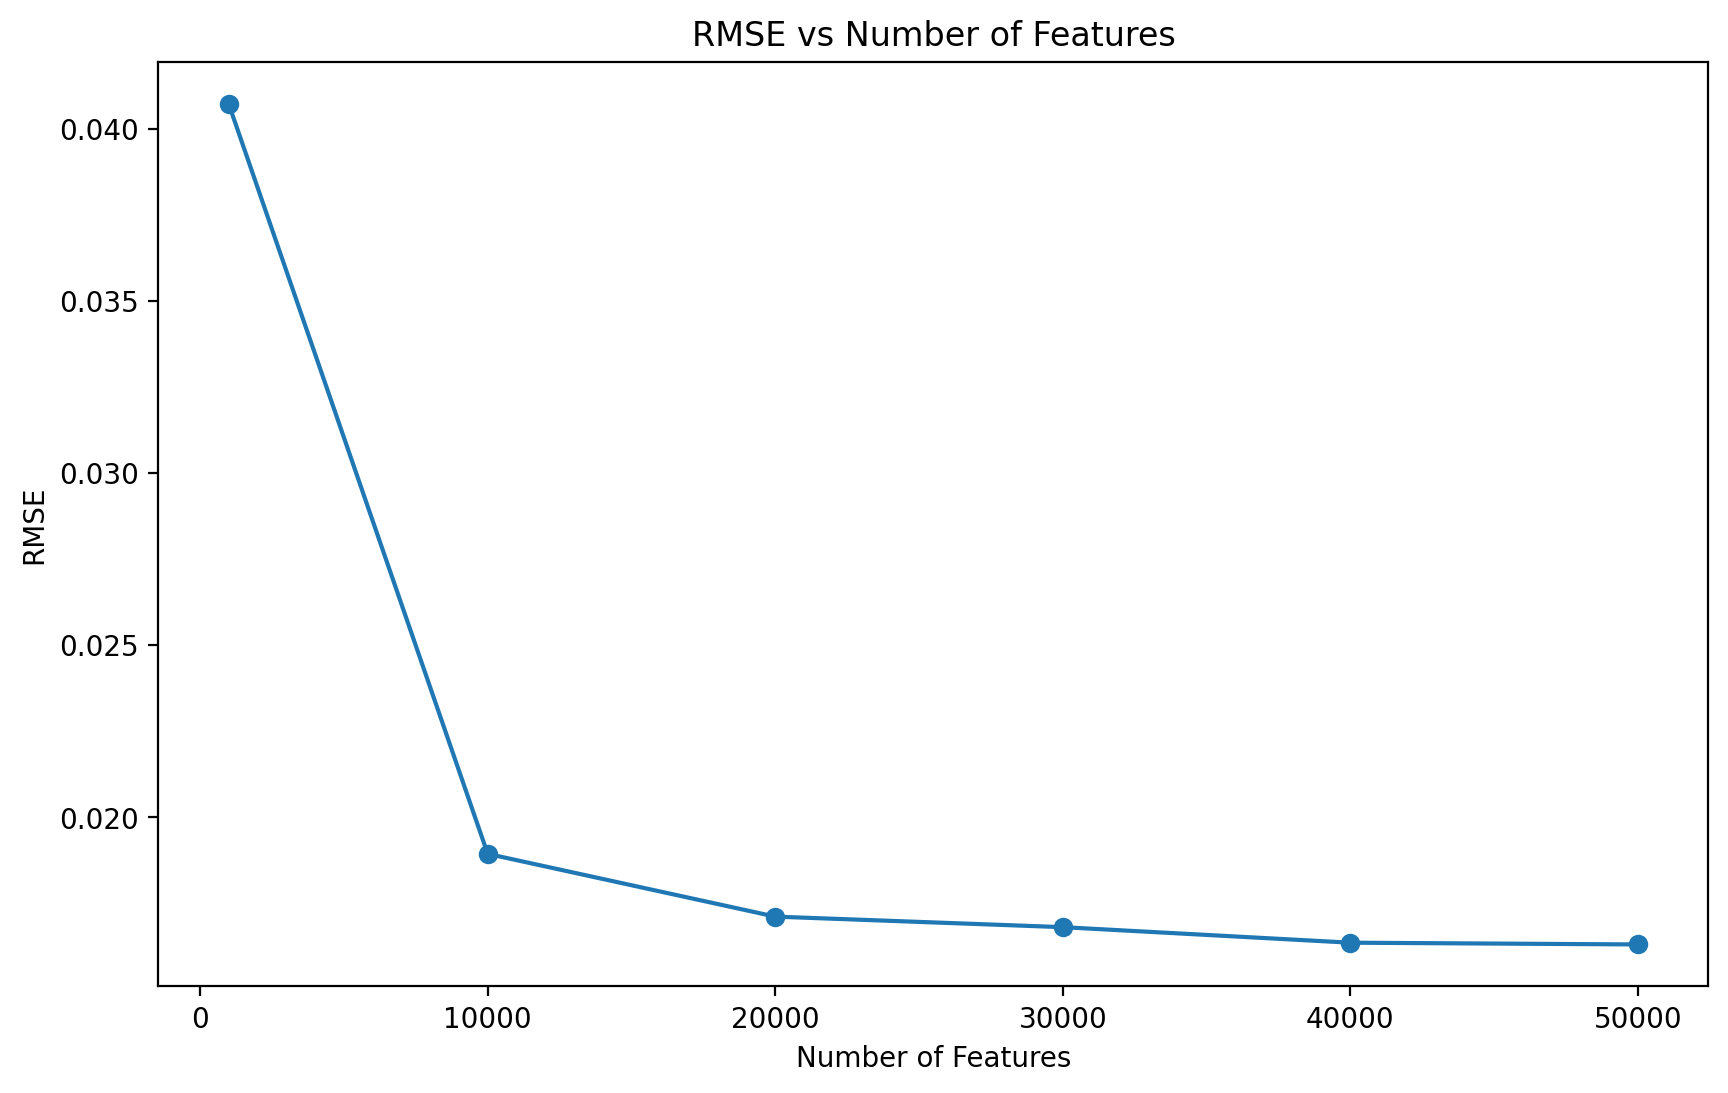

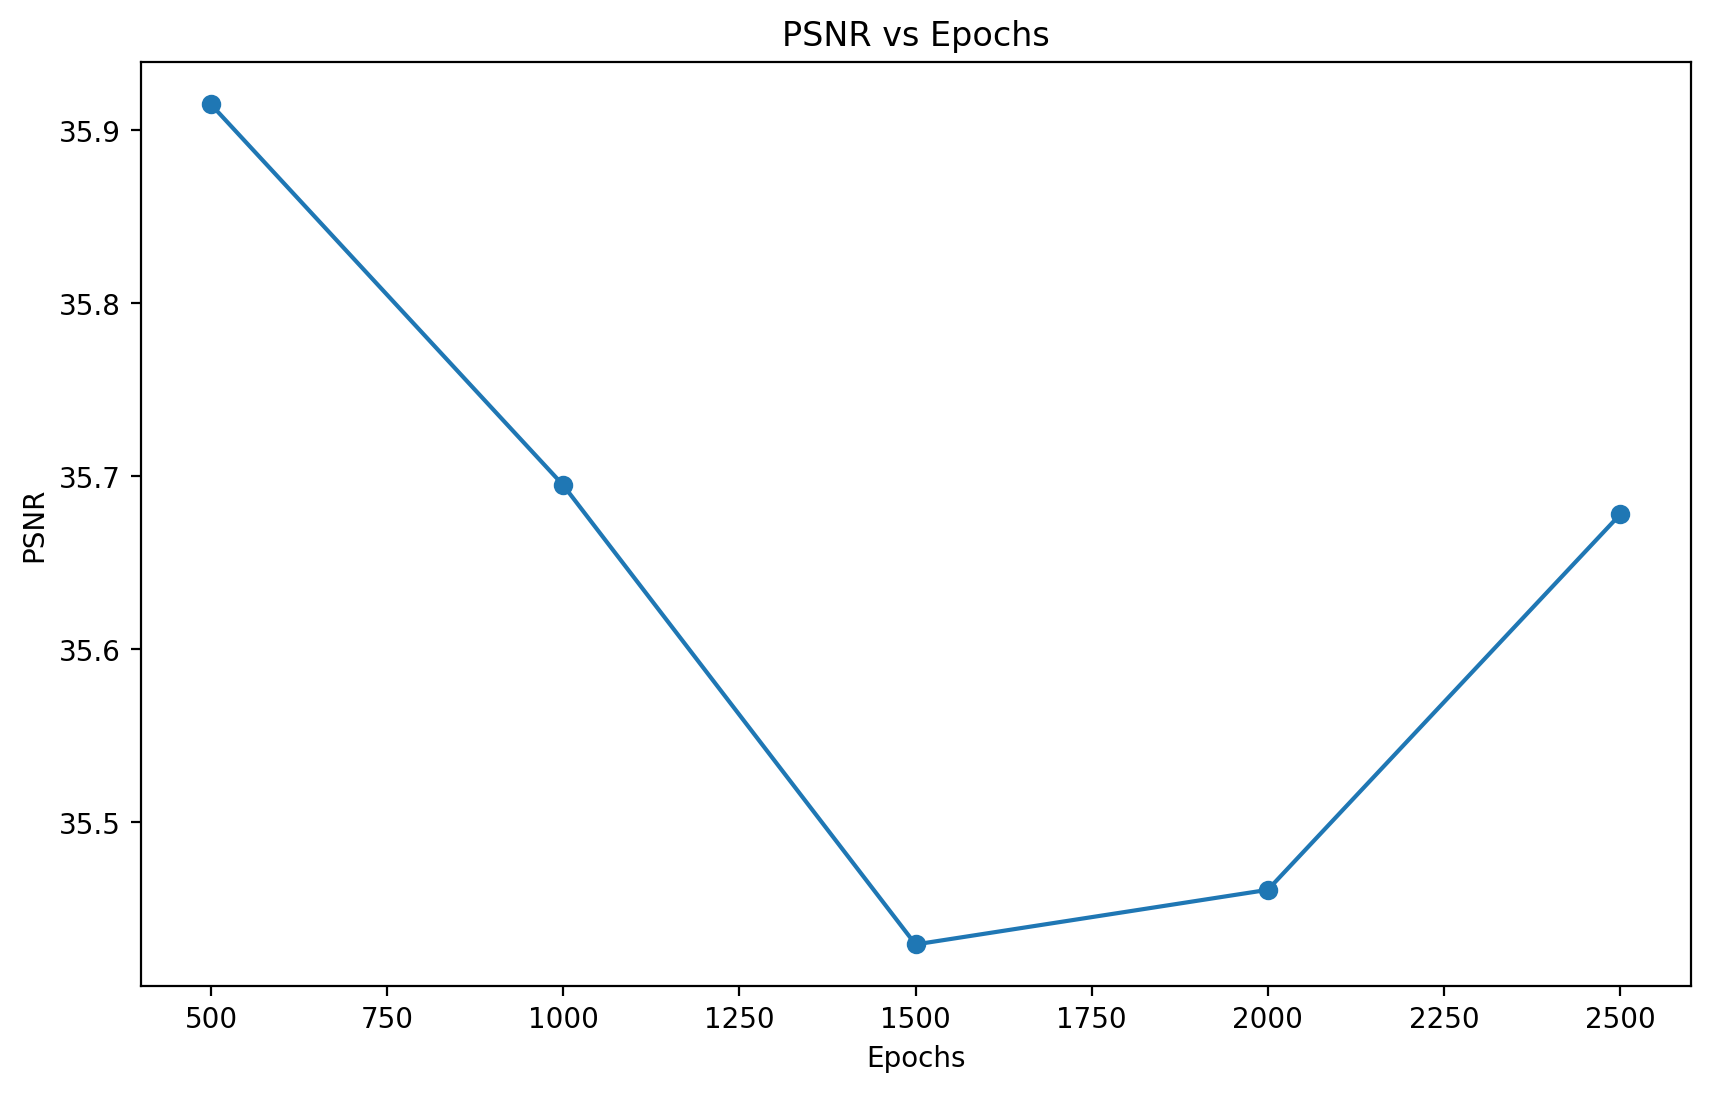

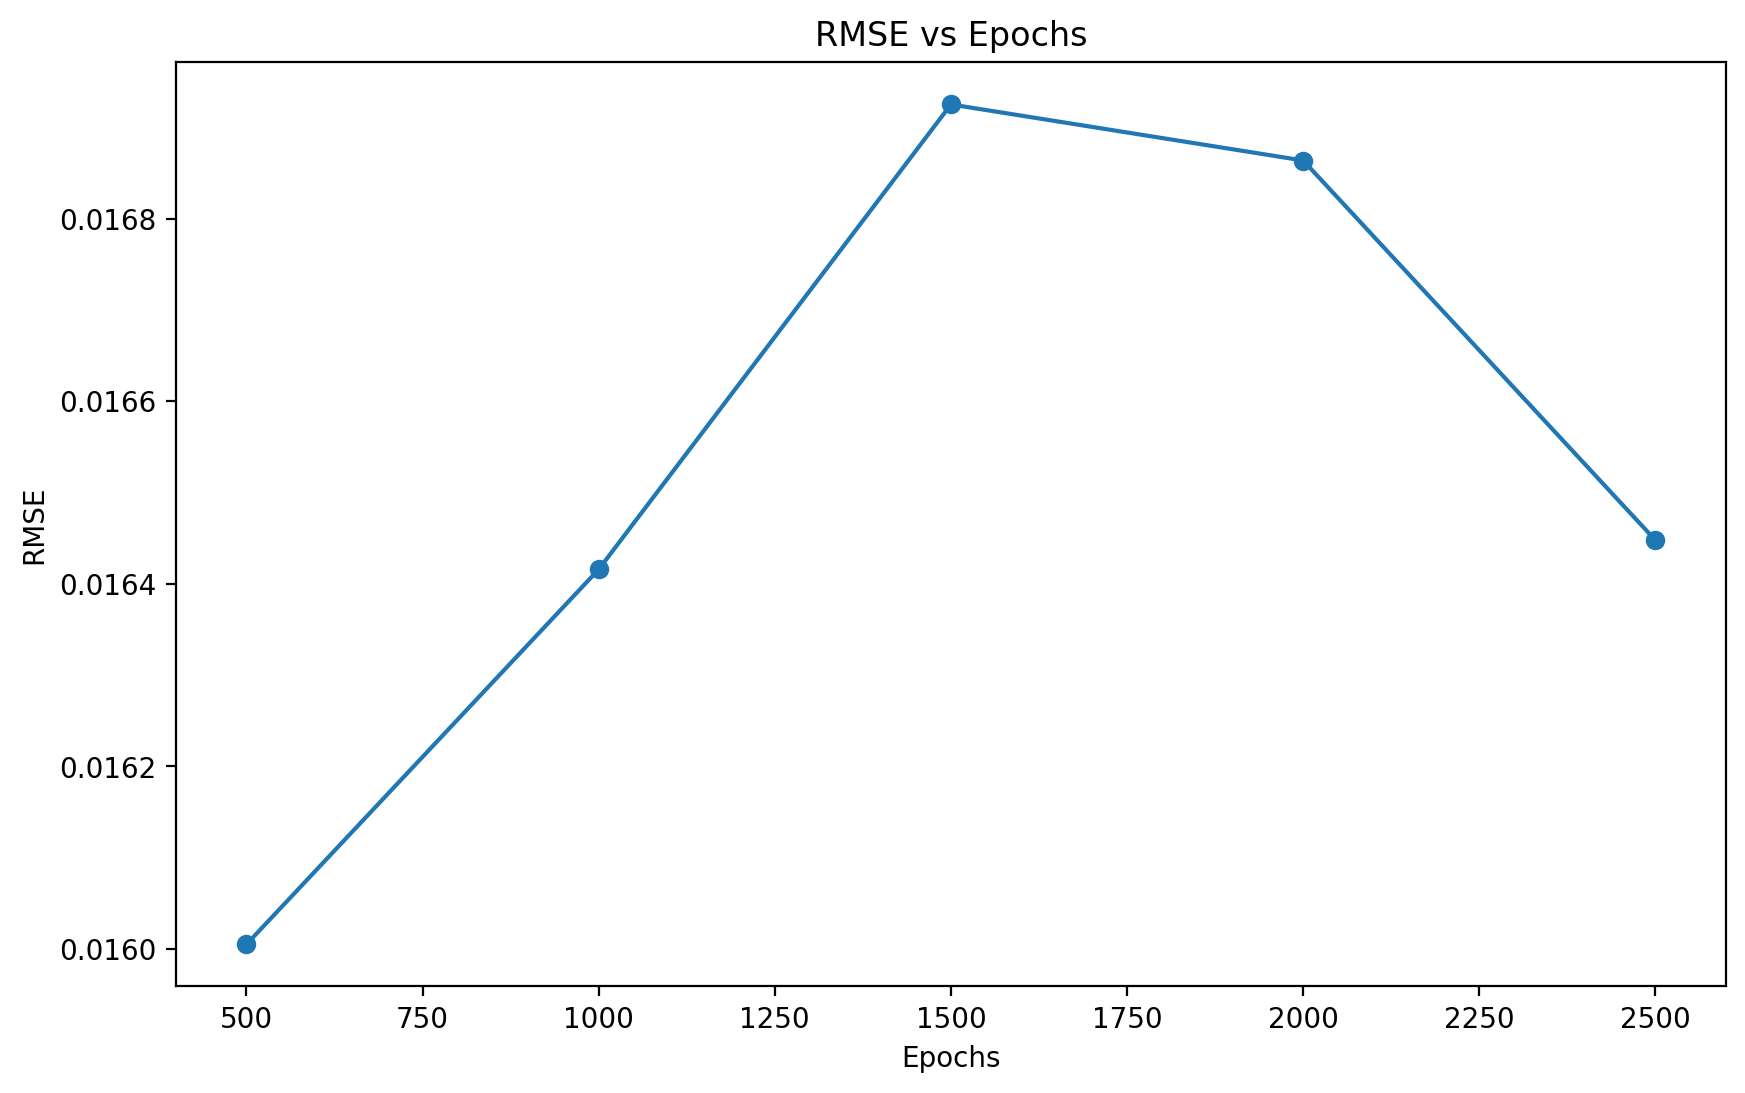

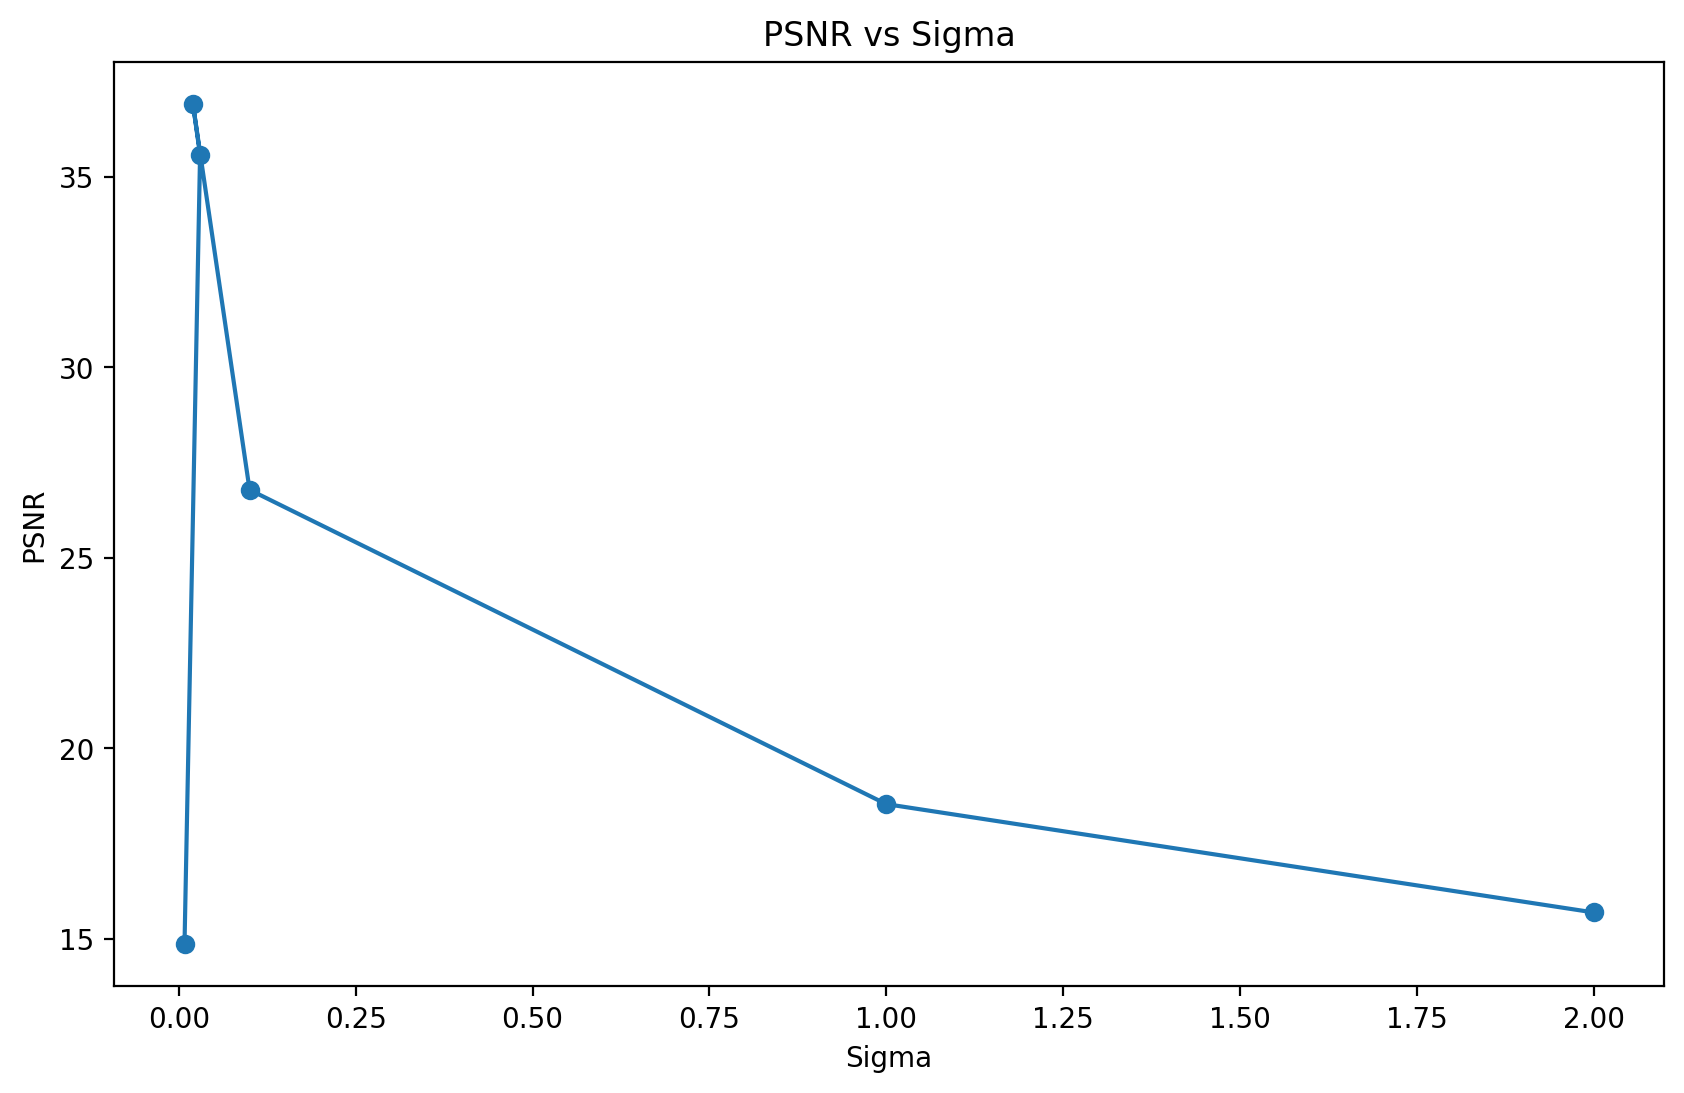

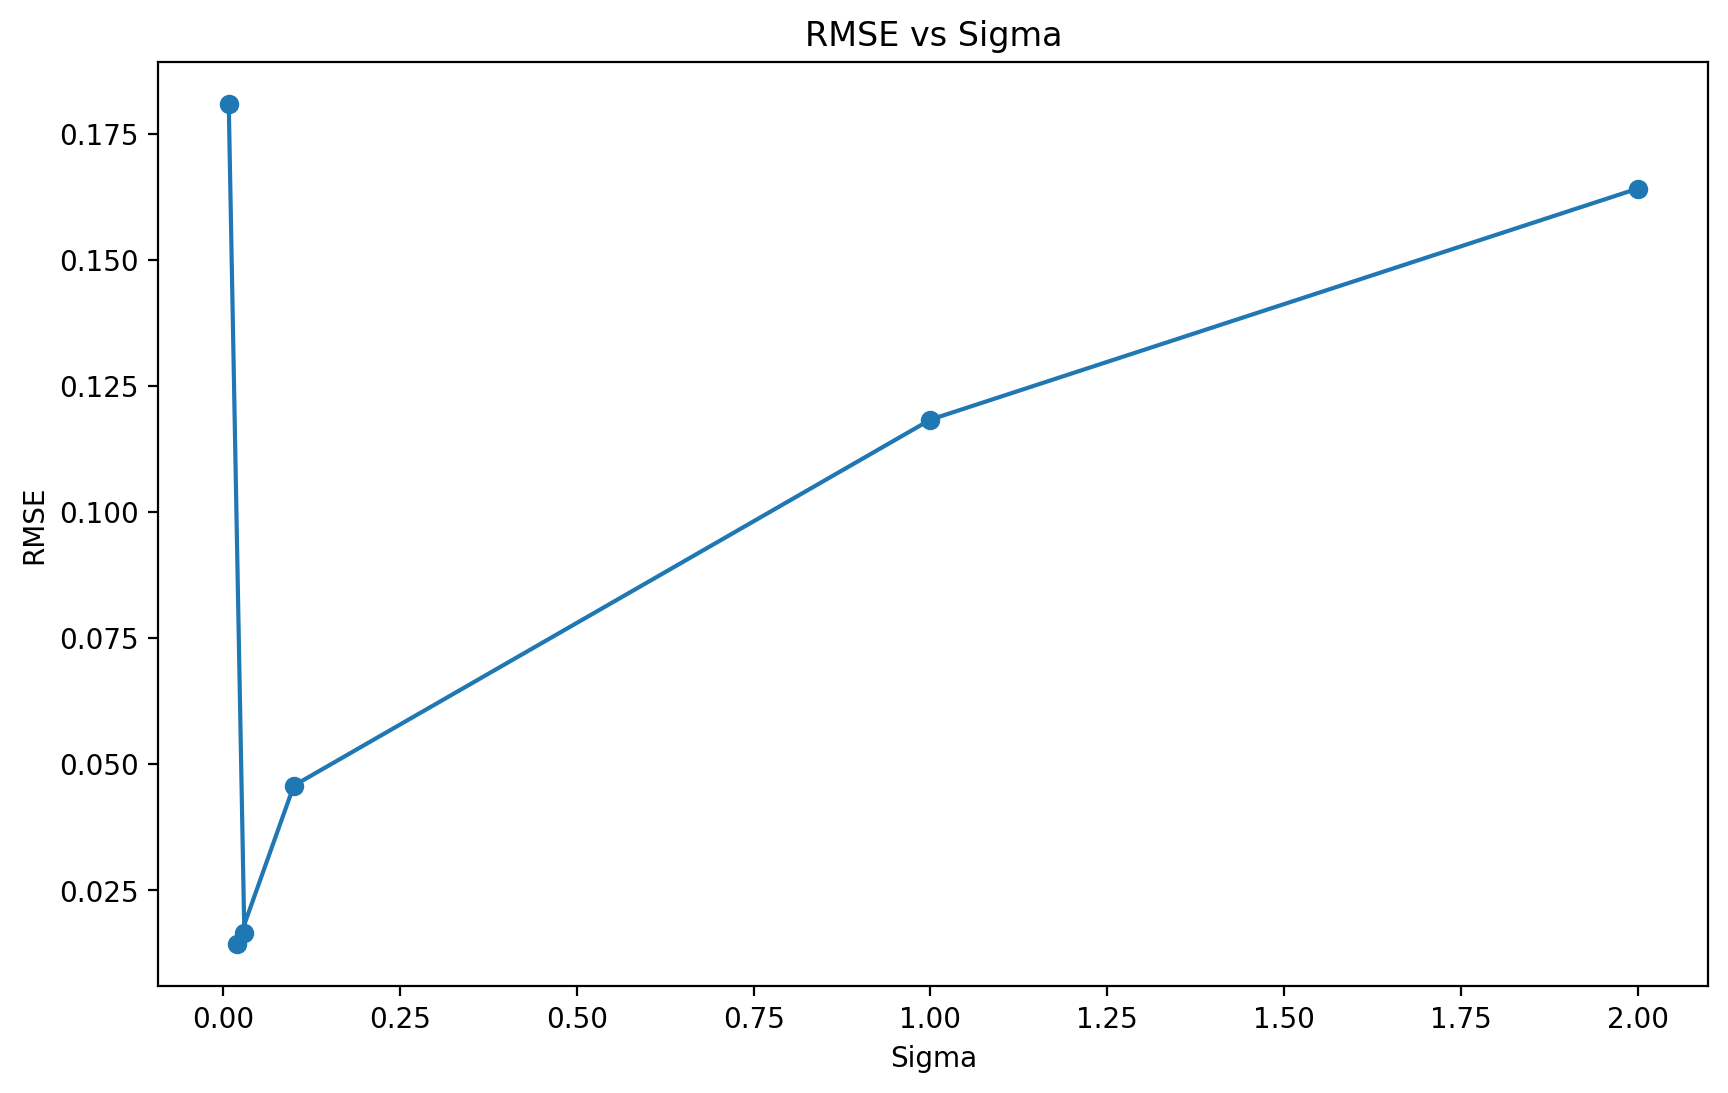

In [62]:
# Function to plot changes in PSNR and RMSE for each varying parameter
def plot_metrics(df, x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_col], df[y_col], marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Plotting PSNR and RMSE for varying num_features
plot_metrics(df_num_features, 'num_features', 'psnr', 'PSNR vs Number of Features', 'Number of Features', 'PSNR')
plot_metrics(df_num_features, 'num_features', 'rmse', 'RMSE vs Number of Features', 'Number of Features', 'RMSE')

# Plotting PSNR and RMSE for varying epochs
plot_metrics(df_epochs, 'epochs', 'psnr', 'PSNR vs Epochs', 'Epochs', 'PSNR')
plot_metrics(df_epochs, 'epochs', 'rmse', 'RMSE vs Epochs', 'Epochs', 'RMSE')

# Plotting PSNR and RMSE for varying sigma
plot_metrics(df_sigma, 'sigma', 'psnr', 'PSNR vs Sigma', 'Sigma', 'PSNR')
plot_metrics(df_sigma, 'sigma', 'rmse', 'RMSE vs Sigma', 'Sigma', 'RMSE')